# caso de estudio

## Canny nms

Escribe una implementación sencilla de la etapa de **supresión de no máximos** del método de Canny, preferiblemente usando operaciones vectorizadas de numpy.

In [20]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow, subplot, title, plot


def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) #/ 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    imshow(x, 'gray')
    
def grad(x):
    gx =  cv.Sobel(x,-1,1,0)/8
    gy =  cv.Sobel(x,-1,0,1)/8
    return gx,gy

En primer lugar preparamos la operación de discretización de ángulos.

In [21]:
cy,cx = np.mgrid[-50:50,-50:50]

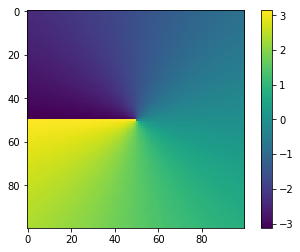

In [22]:
ga = np.arctan2(cy,cx)
imshow(ga); plt.colorbar();

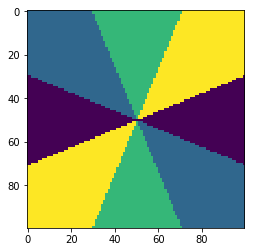

In [23]:
gad = np.round(ga / np.pi * 4) % 4
imshow(gad);

Calculamos el módulo del gradiente y su ángulo discretizado en una imagen de prueba.

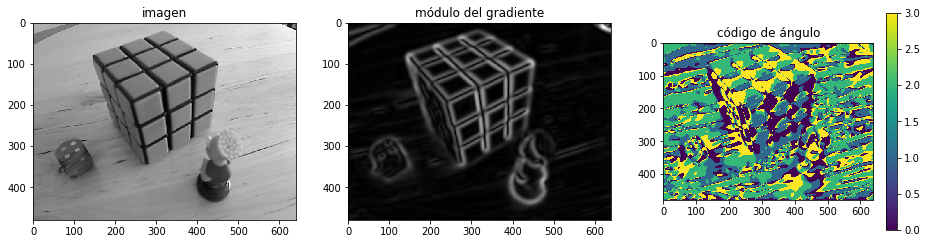

In [24]:
if False:
    x = np.zeros((500,500))
    x[100:400,100:400] = 255
    gx,gy = grad(cv.GaussianBlur(x,(0,0),20))
else:
    x   = gray2float(rgb2gray(readrgb('cube3.png')))
    gx,gy = grad(cv.GaussianBlur(x,(0,0),5))

gm = np.sqrt(gx**2+gy**2)
ga = np.arctan2(gy,gx)
gad = (np.round(ga / np.pi * 4) % 4).astype(np.uint8)

fig(16,4)
subplot(1,3,1); imshowg(x), plt.title('imagen');
subplot(1,3,2); imshowg(gm), plt.title('módulo del gradiente');
subplot(1,3,3); imshow(gad); plt.colorbar(); plt.title('código de ángulo');

In [25]:
%%time

nms = gm.copy() # nms: non maximum supression

r,c = x.shape

for i in range(1,r-1):
    for j in range(1,c-1):
        if    ((gad[i,j] == 0 and (gm[i,j] < gm[i,j-1] or gm[i,j] < gm[i,j+1]))
           or  (gad[i,j] == 1 and (gm[i,j] < gm[i-1,j-1] or gm[i,j] < gm[i+1,j+1]))
           or  (gad[i,j] == 2 and (gm[i,j] < gm[i-1,j] or gm[i,j] < gm[i+1,j]))    
           or  (gad[i,j] == 3 and (gm[i,j] < gm[i-1,j+1] or gm[i,j] < gm[i+1,j-1]))):
            nms[i,j] = 0  

CPU times: user 3.47 s, sys: 0 ns, total: 3.47 s
Wall time: 3.47 s


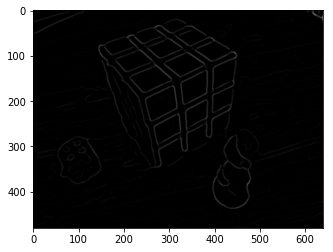

In [26]:
imshow( nms , 'gray', interpolation='bicubic', );

In [27]:
#%%timeit

G  = gm[1:-1,1:-1]
Ga = gm[1:-1,2:]
Gb = gm[:-2,2:]
Gc = gm[:-2,1:-1]
Gd = gm[:-2,:-2]
Ge = gm[1:-1,:-2]
Gf = gm[2:,:-2]
Gg = gm[2:,1:-1]
Gh = gm[2:,2:]

A = gad[1:-1,1:-1]

mask = ( (A==0) & (G > Ga) & (G > Ge) 
       | (A==1) & (G > Gd) & (G > Gh) 
       | (A==2) & (G > Gc) & (G > Gg)
       | (A==3) & (G > Gb) & (G > Gf) )

canny = np.zeros_like(G)
canny[mask]=G[mask]

(Las medidas de timpo no son totalmente fiables.) El tiempo de cómputo en esta máquina está alrededor de 11ms ($\simeq 70\times$)

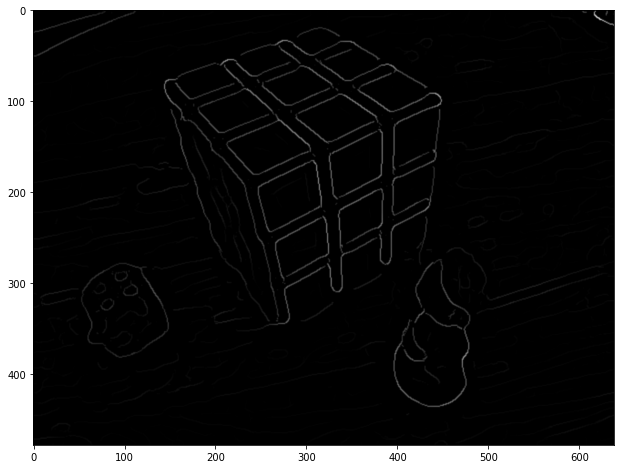

In [28]:
fig(12,8)
imshow( canny, 'gray', interpolation='bicubic');

## interfaz con C

El código anterior se puede acelerar aún más si lo escribimos en un lenguaje compilado. No es complicado escribir [extensiones](https://docs.scipy.org/doc/numpy-1.13.0/user/c-info.python-as-glue.html) para manipular arrays de numpy.

### fortran

El interfaz con fortran es especialmente simple. La herramienta `f2py` puede invocarse automáticamente desde código Python normal o desde el notebook con la [fortran magic](https://github.com/mgaitan/fortran_magic). Las versiones modernas de fortran son muy adecuadas para el procesamiento de datos numéricos, con la ventaja de una intercomunicación directa con los arrays multidimensionales de numpy.

El código de supresión de no máximos que escribimos inicialmente con bucles de Python puede trasladarse directamente a fortran. En este lenguaje la evaluación de expresiones lógicas no hace "cortocircuito", por lo que en la implementación siguiente las condiciones se implementan en varios niveles para reducir las comparaciones innecesarias. 

In [10]:
%load_ext fortranmagic

/home/robot/miniconda/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [11]:
%%fortran
subroutine fnms(m, a, nms)
    real, intent(in)    :: m(:,:)
    integer, intent(in) :: a(:,:)
    real, intent(out)   :: nms(size(m, 1),size(m,2))
    integer :: i,j
    logical :: ok
    nms=0
    do i =2,size(m,1)-1
        do j=2, size(m,2)-1
            v = m(i,j)
            if (a(i,j)==0) then
                if (v > m(i,j-1) .and. v > m(i,j+1)) nms(i,j) = v
                continue
            end if
            if (a(i,j)==1) then
                if (v > m(i-1,j-1) .and. v > m(i+1,j+1)) nms(i,j) = v
                continue
            end if
            if (a(i,j)==2) then
                if (v > m(i-1,j) .and. v > m(i+1,j)) nms(i,j) = v
                continue
            end if
            if (a(i,j)==3) then
                if (v > m(i-1,j+1) .and. v > m(i+1,j-1)) nms(i,j) = v
            end if
        end do
    end do

end subroutine fnms

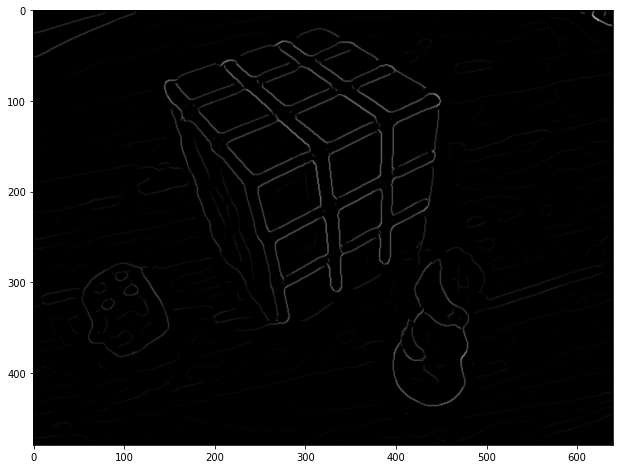

In [12]:
nms = fnms(gm,gad)

fig(12,8)
imshow(nms, 'gray', interpolation='bicubic');

El wrapper de fortran admite slices sin problemas, e incluso adapta los tipos.

In [13]:
%%timeit
nms = fnms(gm,gad)

6.16 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Bajamos a unos 6ms.

### C

Vamos a intentar mejorarla un poco más usando C plano para acceder directamente a los arrays de imagen.

La forma de crear un interfaz con C se explicará en detalle en el laboratorio. Cuando esté terminado tendremos una función *wrapper* que admite los tipos de Python.

In [14]:
import cfuns

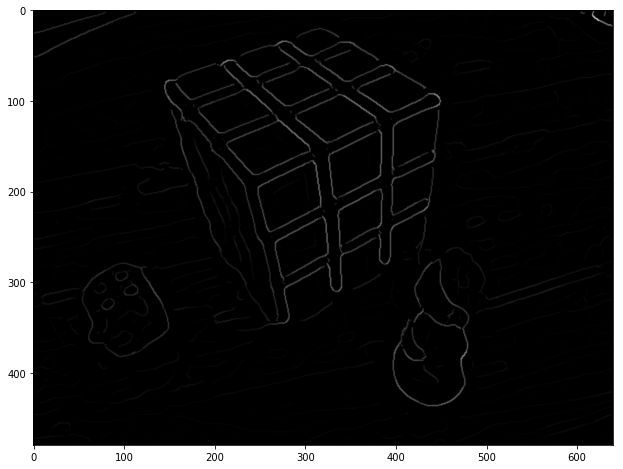

In [15]:
cnms = cfuns.nms(gm,gad)

fig(12,8)
imshow(cnms, 'gray', interpolation='bicubic');

In [16]:
%%timeit
cnms = cfuns.nms(gm,gad)

4.24 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Si recompilamos con optimización bajamos a 2ms.

Es una mejora significativa pero cuyo impacto en el rendimiento global dependerá mucho del resto de etapas de la cadena de proceso. Solo tiene sentido dedicar tiempo a optimizar las etapas más lentas.

La implementación en C no admite directamente slices, pero si es necesario hacemos una copia de las entradas.

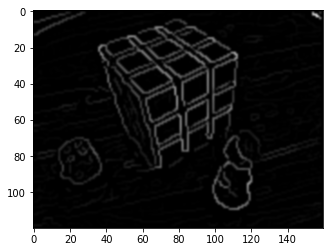

In [17]:
cnms = cfuns.nms(gm[::4,::4].copy(),gad[::4,::4].copy())

imshow(cnms, 'gray', interpolation='bicubic');

Comparemos el rendimiento con la implementación de OpenCV.

In [18]:
xs = cv.GaussianBlur(x,(0,0),5).astype(np.uint8)

In [19]:
%%timeit

cannycv = cv.Canny(xs,20,60)

1.72 ms ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Es mucho más rápido, teniendo en cuenta que tiene que calcular los gradientes y aplicar el doble umbralizado. Podemos echar un vistazo al código fuente [canny.cpp](https://github.com/opencv/opencv/blob/master/modules/imgproc/src/canny.cpp). Son más de 1000 líneas de código C++ con implementaciones alternativas dependiendo de las instrucciones disponibles en cada procesador.